#### Integrin
#### DMap and decoder

#### reference notebook: cg_300_integrated_training_integrin_dmap_decoder-generatePoints.ipynb

## setup

In [ ]:
import os
import sys
import math
import time
import pickle
import copy
#import mdtraj
import MDAnalysis as mda
#import pyemma
#import pyemma.util.contexts
import networkx as nx
import random
#import parmed as pmd
import acpype
import pandas as pd
from MDAnalysis.analysis import distances


import numpy as np
from scipy.linalg import eigh
from scipy.spatial.distance import pdist
from scipy.interpolate import interp1d
import matplotlib as mpl
from matplotlib import ticker
if os.environ.get('DISPLAY','') == '':
    print('no display found. Using non-interactive Agg backend')
    mpl.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
#import torch.optim as optim
#import torch.nn as nn
#from torchviz import make_dot
#from torch.utils.data import Dataset, TensorDataset, DataLoader
#from torch.utils.data.dataset import random_split
#from tqdm import tqdm

#import deeptime
#from deeptime.decomposition import TICA
#from deeptime.clustering import KMeans
##import mdshare

from sklearn.preprocessing import MinMaxScaler

from jax import numpy as jnp, jit, vmap
from MDAnalysis.analysis import rms #diffusionmap, align, rms

import nglview as nv


In [3]:
#from lss.snrv.snrv import Snrv, load_snrv
#from molgen.molgen.models import WGANGP
from importlib import reload 

import sys
sys.path.append('../../')

import codes.dMap_JAX 
reload(codes.dMap_JAX )

from codes.dMap_JAX import dMap_jax, rmsd_jax
from codes.dMap_JAX import diff_plots




#### plot settings

In [5]:
showPlots=1
useMagics=1
if useMagics:
    %matplotlib inline
    #%matplotlib notebook
    %load_ext autoreload
    %autoreload 2
    %reload_ext autoreload
    
font = {'weight' : 'normal',
        'size'   : 25}

plt.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### load saved integrin trajectories 

In [6]:
#### save eigen values

with open(r"../../gan_saved_models/integrin_aa_cg_300_original_aligned_2450_pertraj.pkl", "rb") as input_file:
    saved_traj = pickle.load(input_file)

cat_trajs = saved_traj['cat_trajs']
aligned_cat_trajs = saved_traj['aligned_cat_trajs']
aligned_cat_excl_trajs = saved_traj['aligned_cat_excl_trajs']


#### load dMaps

In [7]:
#### save eigen values

with open(r"../../gan_saved_models/evecs_evals_integrin_aa_cg_300.pkl", "rb") as input_file:
    dMaps_saved = pickle.load(input_file)

lamb = dMaps_saved['lamb']
psi = dMaps_saved['psi']

#### out-of-sample points

In [8]:
#### save eigen values

#with open(r"evecs_evals_nystrom_integrin_aa_cg_300.pkl", "rb") as input_file:
#    dMaps_saved_out = pickle.load(input_file)
#
#lamb_out = dMaps_saved_out['lamb']
#psi_out = dMaps_saved_out['psi']

In [9]:
#assert (lamb == lamb_out).all()

#### Decoder on the net data

In [10]:

from molgen.models import WGANGP
import torch


In [9]:
#cat_trajs.shape

#### visualize, if needed

In [10]:
### create a universe for CG model [from example in MDAnalysis]

n_residues = 300
n_atoms = n_residues

# create resindex list
resindices = np.arange(n_residues)

# all water molecules belong to 1 segment
segindices = [0] * n_residues

# create the Universe
f_cg_1_universe = mda.Universe.empty(n_atoms,
                                 n_residues=n_residues,
                                 atom_resindex=resindices,
                                 residue_segindex=segindices,
                                 trajectory=True) # necessary for adding coordinates




### topology attributes
from MDAnalysis.coordinates.memory import MemoryReader

f_cg_1_universe.add_TopologyAttr('name', ['CG']*n_residues)
f_cg_1_universe.add_TopologyAttr('type', ['CG']*n_residues)
f_cg_1_universe.add_TopologyAttr('resid', list(range(1, n_residues+1)))
f_cg_1_universe.add_TopologyAttr('segid', ['INT'])



In [12]:
aligned_cat_trajs.shape

(9800, 300, 3)

In [25]:

#### frame 0 positions

f_cg_1_universe.atoms.positions = aligned_cat_trajs[2450*3]
f_cg_1_universe.load_new(np.array(aligned_cat_trajs[2450*3:2450*4][::25]), format=MemoryReader)


view = nv.show_mdanalysis(f_cg_1_universe)

# clear representations
#view.clear_representations()

#view.add_representation('spacefill')
view._remote_call("setSize", target="Widget", args=["1000px", "500px"])
#?view.center_view()

# specify color
view.add_representation('spacefill', selection=np.arange(169), color='blue', radius=2.5, opacity=0.85)
view.add_representation('spacefill', selection=np.arange(169,300), color='red', radius=2.5, opacity=0.85)
view.add_representation('cartoon', color='black')


view

NGLWidget(max_frame=97)

#### prepare for decoder

In [11]:
real_trj_list = [aligned_cat_trajs[0:2450].reshape(2450, -1),
                 aligned_cat_trajs[2450:2450*2].reshape(2450, -1),
                 aligned_cat_trajs[2450*2:2450*3].reshape(2450, -1), 
                 aligned_cat_trajs[2450*3:2450*4].reshape(2450, -1)]

real_trj_list = [torch.tensor(x).float() for x in real_trj_list]

print(real_trj_list[0].shape)

psi_list = [psi[0:2450, 1:5],
            psi[2450:2450*2, 1:5],
            psi[2450*2:2450*3, 1:5],
            psi[2450*3:2450*4, 1:5]]

psi_list = [torch.tensor(x) for x in psi_list]

print(psi_list[0].shape)

#psi_out_list = [psi_out[0:2450, 1:5],
#            psi_out[2450:2450*2, 1:5],
#            psi_out[2450*2:2450*3, 1:5],
#            psi_out[2450*3:2450*4, 1:5]]
#
#psi_out_list = [torch.tensor(x) for x in psi_out_list]
#
#print(psi_out_list[0].shape)


torch.Size([2450, 900])
torch.Size([2450, 4])


In [12]:
psi_list[0].shape[1]

4

In [13]:

f_model_gan = WGANGP(feature_dim=real_trj_list[0].shape[1], condition_dim=psi_list[0].shape[1], 
                     gen_hidden_dim=256, dis_hidden_dim=256, lambda_gp=10.0, n_critic=5, 
                     latent_dim=128, lr=5e-5, opt='rmsprop')
             

### Train if needed

In [18]:
#import os
#del os.environ['LD_LIBRARY_PATH']
#del os.environ['PATH']
#
#f_model_gan.fit(real_trj_list, psi_list, batch_size=1000, max_epochs=1000, log=True)
#
#

/work2/03273/tg825722/shared-folder-siva/doe/env_snrv/lss/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 34: CUDA driver is a stub library (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/home1/03273/tg825722/.local/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home1/03273/tg825722/.local/lib/python3.9/site-pack ...
  rank_zero_warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home1/03273/tg825722/.

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


WGANGP(
  (generator): SimpleGenerator(
    (model): Sequential(
      (0): Linear(in_features=132, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): SiLU()
      (6): Linear(in_features=256, out_features=256, bias=True)
      (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Linear(in_features=256, out_features=900, bias=True)
      (10): Tanh()
    )
  )
  (discriminator): SimpleDiscriminator(
    (model): Sequential(
      (0): Linear(in_features=904, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): SiLU()
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): SiLU()
      (6)

In [19]:
#f_model_gan.save('wgangp_b_1000_e1000.ckpt')

### Load saved GAN

In [14]:
f_model_gan = f_model_gan.load_from_checkpoint('../../gan_saved_models/wgangp_b_100_e1000.ckpt')

#### visualize fake points at training space latent points

In [32]:
gen_traj = []
for i in range(4):
    gen_traj.append(f_model_gan.generate(psi_list[i]))

gen_traj = np.concatenate(gen_traj, axis=0).reshape(-1,300,3).reshape(-1,300,3)
### create a universe for CG model [from example in MDAnalysis]

n_residues = 300
n_atoms = n_residues

# create resindex list
resindices = np.arange(n_residues)

# all water molecules belong to 1 segment
segindices = [0] * n_residues

# create the Universe -- for train
gen_f_cg_1_universe = mda.Universe.empty(n_atoms,
                                 n_residues=n_residues,
                                 atom_resindex=resindices,
                                 residue_segindex=segindices,
                                 trajectory=True) # necessary for adding coordinates

### topology attributes
from MDAnalysis.coordinates.memory import MemoryReader

f_cg_1_universe.add_TopologyAttr('name', ['CG']*n_residues)
f_cg_1_universe.add_TopologyAttr('type', ['CG']*n_residues)
f_cg_1_universe.add_TopologyAttr('resid', list(range(1, n_residues+1)))
f_cg_1_universe.add_TopologyAttr('segid', ['INT'])

#### frame 0 positions

gen_f_cg_1_universe.atoms.positions = gen_traj[2450*3]

gen_f_cg_1_universe.load_new(np.array(gen_traj[2450*3:2450*4][::25]), format=MemoryReader)



<Universe with 300 atoms>

In [34]:

view = nv.show_mdanalysis(gen_f_cg_1_universe)

# clear representations
#view.clear_representations()

#view.add_representation('spacefill')
view._remote_call("setSize", target="Widget", args=["1000px", "500px"])
#?view.center_view()

# specify color
view.add_representation('spacefill', selection=np.arange(169), color='blue', radius=2.5, opacity=0.85)
view.add_representation('spacefill', selection=np.arange(169,300), color='red', radius=2.5, opacity=0.85)
view.add_representation('cartoon', color='black')


view

NGLWidget(max_frame=97)

### Interpolate points

In [9]:
#uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.asarray(vectors)

latent_points = [interpolate_points(psi[:,1:5][1000], psi[:,1:5][3000])]  # bent-int1
latent_points.append( interpolate_points(psi[:,1:5][1000], psi[:,1:5][5000]) ) #bent-int2
latent_points.append( interpolate_points(psi[:,1:5][1000], psi[:,1:5][8000]) ) #bent-open
latent_points.append( interpolate_points(psi[:,1:5][3000], psi[:,1:5][5000]) ) #int1-int2
latent_points.append( interpolate_points(psi[:,1:5][3000], psi[:,1:5][8000]) ) #int1-open
latent_points.append( interpolate_points(psi[:,1:5][5000], psi[:,1:5][8000]) ) #int2-open



/tmp/ipykernel_11757/1407984384.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(['bent', 'int1', 'int2', 'open'], size=18)


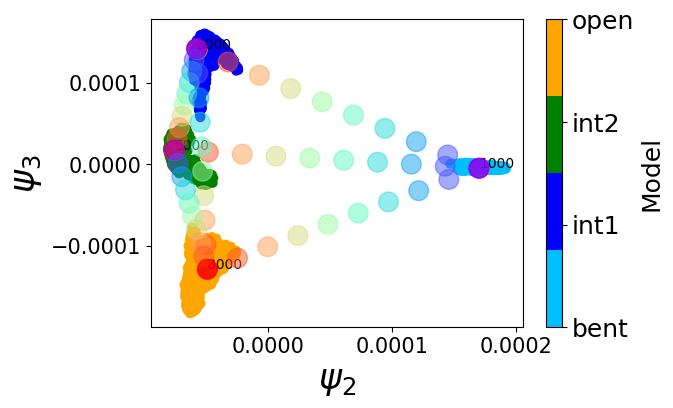

In [13]:
%matplotlib notebook
%matplotlib inline

import mplcursors
import matplotlib.cm as cm

def plot3D_interactive(psi, eps, plot_stride=1, select_axis_2d=[1, 2], skip_lead=True, colorMap='blue', cmap='Accent', ticks=[1, 2, 3, 4, 5, 6], colorbar=True, colorlabel='Traj', skip_3D=False, figSuffix=''):

    if skip_lead:
        lead = 1
    else:
        lead = 0
    
    fig = plt.figure(figsize = (6,4))
    ax = fig.add_subplot(111)#, projection='3d')
    
    norm = plt.Normalize()
    color_map = plt.cm.coolwarm(norm(colorMap))
    
    im = ax.scatter(psi[::plot_stride,lead], psi[::plot_stride,lead+1], c=colorMap, cmap=cmap)
    
    for fr in [1000, 3000, 5000, 8000]:
        
        ax.scatter(psi[::plot_stride,1:4][fr][0], psi[::plot_stride,1:4][fr][1], marker='o', s=200, color='gold', alpha=.5)
        x = psi[::plot_stride,1:4][fr][0]
        y = psi[::plot_stride,1:4][fr][1]
        label=fr
        ax.text(x, y, '%s' % (label), size=10, zorder=1, color='black')
        
    
    for i in range(0,6):#len(latent_points)):
        colors = cm.rainbow(np.linspace(0, 1, len(latent_points[i])))
        ax.scatter(latent_points[i][:,0], latent_points[i][:,1], marker='o', s=200, color=colors, alpha=.5)
        
        
    
    
    mplcursors.cursor(ax).connect("add", lambda sel: sel.annotation.set_text(sel.index))
    
    if colorbar:
        if ticks:
            cbar = plt.colorbar(im, ax=ax, ticks=ticks)
        else:
            cbar = plt.colorbar(im, ax=ax)
        #im.set_clim(model_loss_eigen['feat_evecs_SRV_unbiased'][:,ii+1].min(), model_loss_eigen['feat_evecs_SRV_unbiased'][:,ii+1].max())
        cbar.set_label(colorlabel, size=18)
        cbar.set_ticklabels(['bent', 'int1', 'int2', 'open'], size=18)
        
    
    ax.set_xlabel('$\psi$$_{'+str(lead+1)+'}$', labelpad=5)
    ax.set_ylabel('$\psi$$_{'+str(lead+2)+'}$', labelpad=5)
    #ax.set_zlabel('$\psi$$_{'+str(lead+3)+'}$', labelpad=30)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #ax.set_box_aspect(aspect=(4,4,4), zoom=0.8)
    
    # disable auto rotation
    #ax.zaxis.set_tick_params(labelsize=15)
    #ax.zaxis.set_rotate_label(False)
    
    
    plt.show()
        
    fig.tight_layout()
    #fig.savefig('interactive_evecs_'+str(lead+1)+str(lead+2)+str(lead+3)+'_'+str(eps)+ '_' + figSuffix + '.png', dpi=300)
    #plt.close()
        
colors = [np.ones(2450)*1, np.ones(2450)*2, np.ones(2450)*3, np.ones(2450)*4]
lcmap = (mpl.colors.ListedColormap(['deepskyblue', 'blue', 'green', 'orange']) #'red', 'black'
        .with_extremes(over='0.25', under='0.75'))
#colors = tail_distances/10
plot3D_interactive(psi, '0', plot_stride=1, select_axis_2d=[1, 2], skip_lead=True, 
                   colorMap=colors, cmap=lcmap, colorlabel=r'Model', ticks=None,
                   colorbar=True, skip_3D=False, figSuffix = 'bytaildist_rotate_decode_opt1')




In [216]:
latent_points[2][0]

latenSelected=5
folderName='int2-bent'

In [217]:
latent_multiple_decoded_frames = []
for i in range(100):
    
    latent_multiple_decoded_frames.append(f_model_gan.generate(torch.tensor(latent_points[latenSelected]).float()).reshape(-1,300,3))


In [218]:
all_points = []
for j in range(len(latent_points[0])):
    point_1 = []
    for i in range(100):
        point_1.append(np.array(latent_multiple_decoded_frames[i][j]))
        
    all_points.append(np.array(point_1))

all_points = np.array(all_points)
#point_1

In [219]:
all_points.shape

(10, 100, 300, 3)

In [220]:
### create a universe for CG model [from example in MDAnalysis]
cg_1_universe = []
for i in range(all_points.shape[0]):
    n_residues = 300
    n_atoms = n_residues
    
    # create resindex list
    resindices = np.arange(n_residues)
    
    # all water molecules belong to 1 segment
    segindices = [0] * n_residues
    
    # create the Universe
    _cg_1_universe = mda.Universe.empty(n_atoms,
                                     n_residues=n_residues,
                                     atom_resindex=resindices,
                                     residue_segindex=segindices,
                                     trajectory=True) # necessary for adding coordinates
    
    ### topology attributes
    from MDAnalysis.coordinates.memory import MemoryReader
    
    _cg_1_universe.add_TopologyAttr('name', ['CG']*n_residues)
    _cg_1_universe.add_TopologyAttr('type', ['CG']*n_residues)
    _cg_1_universe.add_TopologyAttr('resid', list(range(1, n_residues+1)))
    _cg_1_universe.add_TopologyAttr('segid', ['INT'])
    
    #### frame 0 positions
    
    _cg_1_universe.atoms.positions = all_points[i][0]
    
    _cg_1_universe.load_new(np.array(all_points[i]), format=MemoryReader)
    
    cg_1_universe.append(_cg_1_universe)
    

In [221]:
cg_1_universe

[<Universe with 300 atoms>,
 <Universe with 300 atoms>,
 <Universe with 300 atoms>,
 <Universe with 300 atoms>,
 <Universe with 300 atoms>,
 <Universe with 300 atoms>,
 <Universe with 300 atoms>,
 <Universe with 300 atoms>,
 <Universe with 300 atoms>,
 <Universe with 300 atoms>]

In [224]:
#### save as PDB
for i in range(len(cg_1_universe)):
    cg_1_universe[i].atoms.write("multiple_fake_points_integrin/"+folderName+"/fake_point_"+str(i)+ ".gro")
    with mda.Writer("multiple_fake_points_integrin/"+folderName+"/fake_point_"+str(i)+".xtc", cg_1_universe[i].atoms.n_atoms) as W:
        for ts in cg_1_universe[i].trajectory:
            W.write(cg_1_universe[i].atoms.select_atoms("all"))



In [225]:
#### calculate RMSF
from MDAnalysis.analysis.rms import RMSF

rmsf_fake_points = []
for rep in cg_1_universe:
    print(rep)
    select_all_atoms = rep.select_atoms('index 0 to 299')
    rmsf_fake_points.append( RMSF(select_all_atoms).run() )

<Universe with 300 atoms>
<Universe with 300 atoms>
<Universe with 300 atoms>
<Universe with 300 atoms>
<Universe with 300 atoms>
<Universe with 300 atoms>
<Universe with 300 atoms>
<Universe with 300 atoms>
<Universe with 300 atoms>
<Universe with 300 atoms>


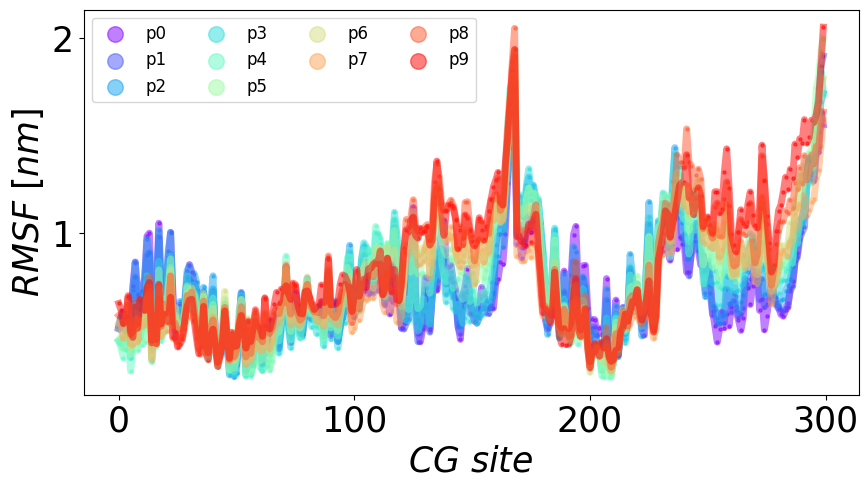

In [226]:
# plot
%matplotlib inline
import matplotlib.ticker as ticker
import matplotlib.cm as cm

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
colors = cm.rainbow(np.linspace(0, 1, len(rmsf_fake_points)))
for i in range(len(rmsf_fake_points)):
    ax.scatter(list(np.arange(300)), rmsf_fake_points[i].results.rmsf/10, 
               color=colors[i], s=5, alpha=0.5, label='p'+str(i))

    ax.plot(list(np.arange(300)), rmsf_fake_points[i].results.rmsf/10, 
            color=colors[i], lw=5, alpha=0.5)
    
    
ax.legend(fontsize=12, ncol=4, markerscale=5)
ax.set_xlabel(r"$CG$ $site$")
ax.set_ylabel(r"$RMSF$ $[nm]$")
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))

ax.set_xlabel(r"$CG$ $site$")
ax.set_ylabel(r"$RMSF$ $[nm]$")
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))


#plt.tight_layout()
#fig.savefig("rmsf_cg_300.png",dpi=150)

In [40]:
view = nv.show_mdanalysis(cg_1_universe[0])

# clear representations
#view.clear_representations()

#view.add_representation('spacefill')
view._remote_call("setSize", target="Widget", args=["1000px", "500px"])
#?view.center_view()

# specify color
view.add_representation('spacefill', selection=np.arange(169), color='blue', radius=3.5, opacity=0.85)
view.add_representation('spacefill', selection=np.arange(169,300), color='red', radius=3.5, opacity=0.85)
view.add_representation('cartoon', color='black')


view

NGLWidget(max_frame=99)

#### get RMSD over multiple decoded frames

In [38]:
#all_points.shape

In [227]:

#### save generated fake points
with open(r"multiple_fake_points_integrin/"+folderName+"/integrin_aa_cg_300_multiple_fake_b100_e1000.pkl", "wb") as f:
    pickle.dump({'all_points': all_points}, f)
    
    

In [228]:
with open(r"multiple_fake_points_integrin/"+folderName+"/integrin_aa_cg_300_multiple_fake_b100_e1000.pkl", "rb") as input_file:
    data_all_points = pickle.load(input_file)

all_points = data_all_points['all_points']


In [229]:
## calculate pairwise RMSD

import os
os.environ['LD_LIBRARY_PATH'] ="$LD_LIBRARY_PATH:/opt/apps/cuda/11.3/lib64"
os.environ['PATH']="$PATH:/opt/apps/xalt/xalt/bin:/opt/apps/cuda/11.3/bin"

for i in range(all_points.shape[0]):
    start = time.time()

    rmsd_jax.run_rmsd(jnp.array(all_points[i]), 
                      batch_ref_frame_size=10, 
                      nref_frames=all_points[i].shape[0] + 1, 
                      output_file_prefix="multiple_fake_points_integrin/"+folderName+"/integrin_pair_rmsd_b100_"+str(i)+"_")
                      #output_file_prefix="integrin_aa_cg_300_integrated_rmsd_data/gan_aa_cg_multiple_fake_data_b100_e1000/integrin_pair_rmsd_b100_"+str(i)+"_")

    print("RMSD calculations finished in {} seconds".format(time.time()-start))


running pairwise rmsd between same traj. Batch: 0
running pairwise rmsd between same traj. Batch: 10
running pairwise rmsd between same traj. Batch: 20
running pairwise rmsd between same traj. Batch: 30
running pairwise rmsd between same traj. Batch: 40
running pairwise rmsd between same traj. Batch: 50
running pairwise rmsd between same traj. Batch: 60
running pairwise rmsd between same traj. Batch: 70
running pairwise rmsd between same traj. Batch: 80
running pairwise rmsd between same traj. Batch: 90
RMSD calculations finished in 4.430118560791016 seconds
running pairwise rmsd between same traj. Batch: 0
running pairwise rmsd between same traj. Batch: 10
running pairwise rmsd between same traj. Batch: 20
running pairwise rmsd between same traj. Batch: 30
running pairwise rmsd between same traj. Batch: 40
running pairwise rmsd between same traj. Batch: 50
running pairwise rmsd between same traj. Batch: 60
running pairwise rmsd between same traj. Batch: 70
running pairwise rmsd betwee

In [230]:
## load pairwise RMSD
import os
os.environ['LD_LIBRARY_PATH'] ="$LD_LIBRARY_PATH:/opt/apps/cuda/11.3/lib64"
os.environ['PATH']="$PATH:/opt/apps/xalt/xalt/bin:/opt/apps/cuda/11.3/bin"


fake_sym_prmsd_jax_nm = []
for i in range(all_points.shape[0]):
    start = time.time()
    
    
    _sym_prmsd_jax = rmsd_jax.load_rmsd(nref_frames=all_points[i].shape[0] + 1, 
                                        batch_ref_frame_size=10, 
                                        input_file_prefix="multiple_fake_points_integrin/"+folderName+"/integrin_pair_rmsd_b100_"+str(i)+"_", 
                                        tol=1e-5)
    fake_sym_prmsd_jax_nm.append(_sym_prmsd_jax/10)



Checking if matrix is symmetric with tol:1e-05
diag_min: 0.0, diag_max: 0.0, 
 is_symmetric: True, diff_symmetric_min:0.0, diff_symmetric_max:0.0 
Checking if matrix is symmetric with tol:1e-05
diag_min: 0.0, diag_max: 0.0, 
 is_symmetric: True, diff_symmetric_min:0.0, diff_symmetric_max:0.0 
Checking if matrix is symmetric with tol:1e-05
diag_min: 0.0, diag_max: 0.0, 
 is_symmetric: True, diff_symmetric_min:0.0, diff_symmetric_max:0.0 
Checking if matrix is symmetric with tol:1e-05
diag_min: 0.0, diag_max: 0.0, 
 is_symmetric: True, diff_symmetric_min:0.0, diff_symmetric_max:0.0 
Checking if matrix is symmetric with tol:1e-05
diag_min: 0.0, diag_max: 0.0, 
 is_symmetric: True, diff_symmetric_min:0.0, diff_symmetric_max:0.0 
Checking if matrix is symmetric with tol:1e-05
diag_min: 0.0, diag_max: 0.0, 
 is_symmetric: True, diff_symmetric_min:0.0, diff_symmetric_max:0.0 
Checking if matrix is symmetric with tol:1e-05
diag_min: 0.0, diag_max: 0.0, 
 is_symmetric: True, diff_symmetric_min:

In [231]:
fake_sym_prmsd_jax_nm[9]

Array([[0.        , 1.0669777 , 1.6182852 , ..., 1.5440762 , 1.2615887 ,
        1.2449019 ],
       [1.0669777 , 0.        , 1.0363983 , ..., 0.7064136 , 0.6745354 ,
        0.7714013 ],
       [1.6182852 , 1.0363983 , 0.        , ..., 0.9021958 , 1.1405276 ,
        0.72568923],
       ...,
       [1.5440762 , 0.7064136 , 0.9021958 , ..., 0.        , 0.62383074,
        0.8355185 ],
       [1.2615887 , 0.6745354 , 1.1405276 , ..., 0.62383074, 0.        ,
        0.9501958 ],
       [1.2449019 , 0.7714013 , 0.72568923, ..., 0.8355185 , 0.9501958 ,
        0.        ]], dtype=float32)

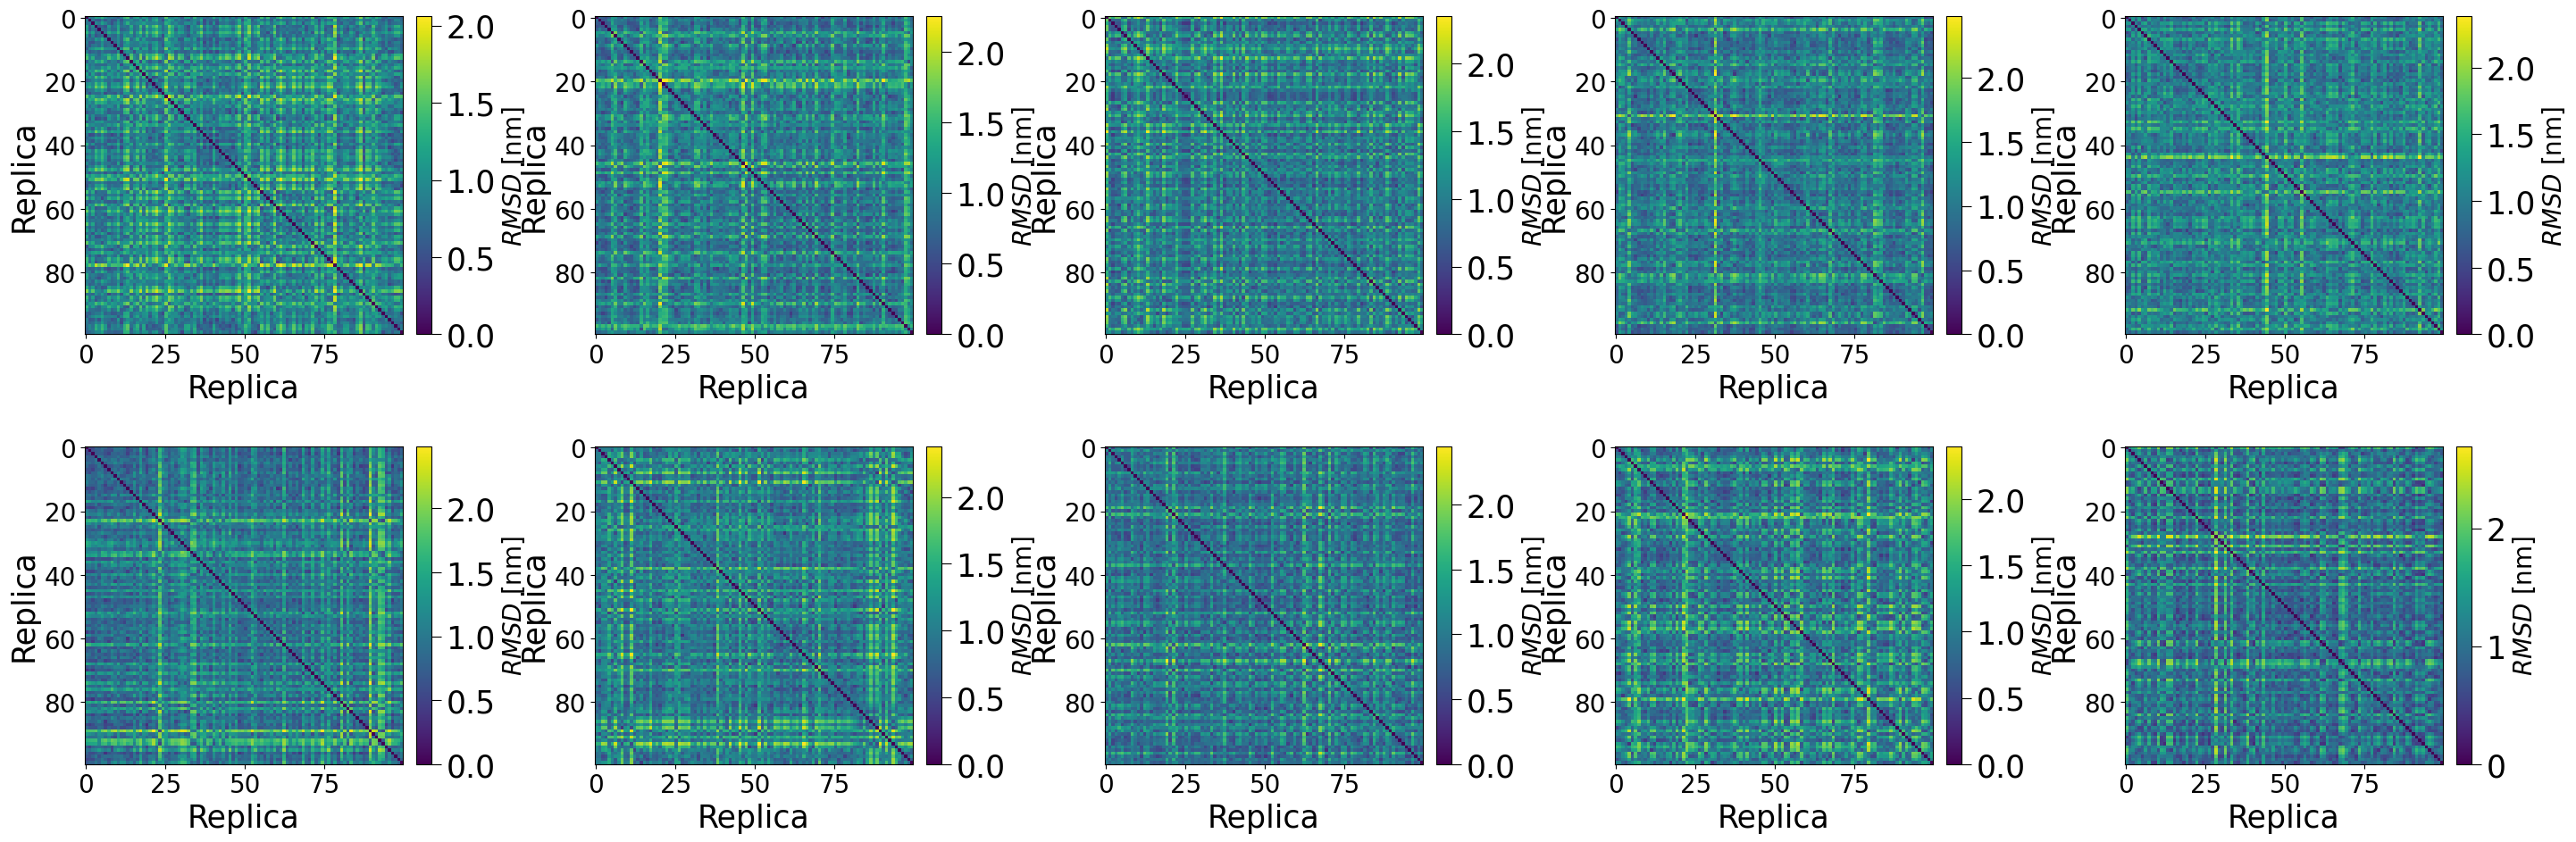

In [232]:

%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
#plot_stride = 100
fig = plt.figure(figsize = (30,10))
plt.subplots_adjust(wspace=0.2, hspace=1.5, bottom=0.,top=0.4)

for x in range(10):
    ax = fig.add_subplot(2,5,x+1)
    
    im = ax.imshow(fake_sym_prmsd_jax_nm[x], cmap='viridis', vmin=0)

    ax.set_xlabel('Replica', fontsize=25)
    ax.set_ylabel('Replica', fontsize=25)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.15)
    
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    
    cb = fig.colorbar(im, cax=cax, orientation='vertical')#, label='$RMSD$ [nm]')
    #cb = plt.colorbar(im, orientation="vertical", pad=0.15)
    cb.set_label(label='$RMSD$ [nm]', size=20)#, weight='n')
    #cb.ax.tick_params(labelsize='normal')
    cb.ax.tick_params(size=8)
    
fig.tight_layout() 
plt.show()
#fig.savefig('jax-rmsd-integrin-full-gan-100batch-1000epoch.png',dpi=150)